# Weather EDA and Cleaning

In [18]:
# Load libraries
import numpy as np
import pandas as pd

In [2]:
# Import data csv
weather = pd.read_csv('../../data/weather.csv')
weather.head().T

,0,1,2,3,4
Station,1,2,1,2,1
Date,2007-05-01,2007-05-01,2007-05-02,2007-05-02,2007-05-03
Tmax,83,84,59,60,66
Tmin,50,52,42,43,46
Tavg,67,68,51,52,56
Depart,14,M,-3,M,2
DewPoint,51,51,42,42,40
WetBulb,56,57,47,47,48
Heat,0,0,14,13,9
Cool,2,3,0,0,0


In [3]:
weather.dtypes

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object

- Many numerical columns are imported as objects.

In [4]:
# Convert Date to date format
weather['Date'] = pd.to_datetime(weather['Date'], format='%Y-%m-%d')

In [5]:
# Calculate missing Tavg as average of Tmax and Tmin
weather.Tavg = weather.apply([lambda row: (row.Tmax + row.Tmin) / 2 if row.Tavg == 'M' else row.Tavg], axis=1)
weather.Tavg = weather.Tavg.astype('float64')

In [6]:
# Fill missing WetBulb from the other station
for k, v in enumerate(weather['WetBulb']):
    if v == 'M' and weather.iloc[k]['Station'] == 1:
        weather.loc[k,'WetBulb'] = weather['WetBulb'][k+1]
    if v == 'M' and weather.iloc[k]['Station'] == 2:
        weather.loc[k,'WetBulb'] = weather['WetBulb'][k-1]
weather['WetBulb'] = pd.to_numeric(weather['WetBulb'])

In [7]:
# Engineer feature for daytime hours
daytime = pd.to_timedelta([i[:2] + ':' + i[2:] + ':00' for i in weather[weather['Station']==1]['Sunset']]) - pd.to_timedelta([i[:2] + ':' + i[2:] + ':00' for i in weather[weather['Station']==1]['Sunrise']])
weather['Daytime'] = list(sum((zip(daytime,daytime)),()))

In [26]:
# Fill trace values as 0.005
weather['PrecipTotal'].replace('  T', '0.005', inplace=True)
# Fill missing values from the other Station
for k, v in enumerate(weather['PrecipTotal']):
    if v == 'M' and weather.iloc[k]['Station'] == 1:
        weather.loc[k,'PrecipTotal'] = weather['PrecipTotal'][k+1]
    if v == 'M' and weather.iloc[k]['Station'] == 2:
        weather.loc[k,'PrecipTotal'] = weather['PrecipTotal'][k-1]
weather['PrecipTotal'] = pd.to_numeric(weather['PrecipTotal'])

In [43]:
# Fill missing values for Depart, Heat, Cool, AvgSpeed from the other station
cols = ['Depart', 'Heat', 'Cool', 'AvgSpeed']
for col in cols:
    for k, v in enumerate(weather[col]):
        if v == 'M' and weather.iloc[k]['Station'] == 1:
            weather.loc[k,col] = weather[col][k+1]
        if v == 'M' and weather.iloc[k]['Station'] == 2:
            weather.loc[k,col] = weather[col][k-1]
    weather[col] = pd.to_numeric(weather[col])

In [50]:
weather[weather['SeaLevel']=='M']

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Daytime
87,2,2007-06-13,86,68,77.0,6,53,62,0,12,...,M,M,M,0.000,M,M,7.0,5,8.6,15:11:00
832,1,2009-06-18,80,61,71.0,1,63,67,0,6,...,0,M,0.0,0.120,29.08,M,6.7,16,7.9,15:13:00
994,1,2009-09-07,77,59,68.0,1,59,62,0,3,...,0,M,0.0,0.000,29.39,M,5.8,3,4.0,12:54:00
1732,1,2011-09-08,75,57,66.0,0,53,59,0,1,...,0,M,0.0,0.005,29.34,M,13.0,2,13.4,12:51:00
1745,2,2011-09-14,60,48,54.0,-11,45,51,11,0,...,M,M,M,0.005,29.47,M,6.0,32,7.3,12:35:00
1756,1,2011-09-20,74,49,62.0,0,54,58,3,0,...,0,M,0.0,0.000,29.26,M,7.3,18,7.3,12:16:00
2067,2,2012-08-22,84,72,78.0,-1,51,61,0,5,...,M,M,M,0.000,29.39,M,4.7,19,5.8,13:37:00
2090,1,2012-09-03,88,71,80.0,12,70,73,0,15,...,0,M,0.0,0.000,29.17,M,4.6,6,4.4,13:05:00
2743,2,2014-07-23,76,64,70.0,-7,56,61,0,5,...,M,M,M,0.000,29.47,M,16.4,2,16.7,14:44:00


In [44]:
weather.dtypes

Station                  int64
Date            datetime64[ns]
Tmax                     int64
Tmin                     int64
Tavg                   float64
Depart                   int64
DewPoint                 int64
WetBulb                  int64
Heat                     int64
Cool                     int64
Sunrise                 object
Sunset                  object
CodeSum                 object
Depth                   object
Water1                  object
SnowFall                object
PrecipTotal            float64
StnPressure             object
SeaLevel                object
ResultSpeed            float64
ResultDir                int64
AvgSpeed               float64
Daytime        timedelta64[ns]
dtype: object

hot and dry conditions are more favorable for West Nile virus than cold and wet.

Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
- Where are these stations among the mosquito traps? Good representation?

M: missing data

- Copy all missing from station 1 to station 2?

Hot: Tmax, Tmin, Tavg, WetBulb(humidity-adjusted), SnowFall
Wet: DewPoint (high: more moisture), PrecipTotal


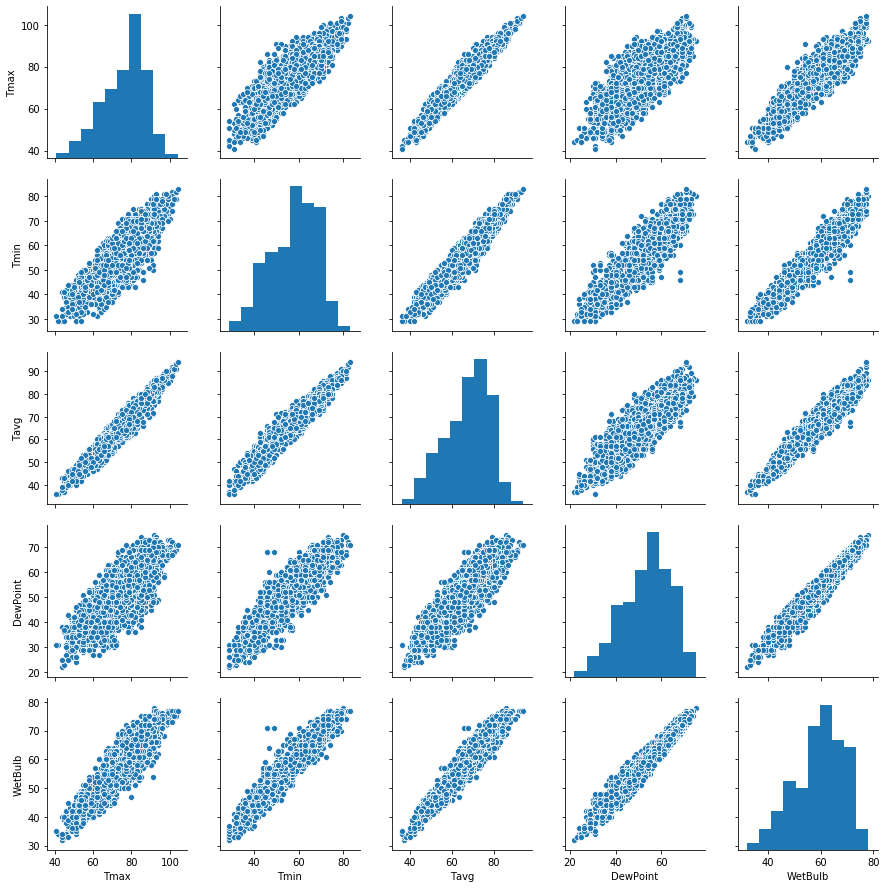

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.pairplot(weather[['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb']])